## Overview
This project ... [purpose for doing project AKA for class to fulfill x learning objectives...]. [what is this specific dataset/project do]

## Importing Data & Packages

In [2]:
pip install split-folders

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import seaborn as sns
sns.set_style('darkgrid')
import shutil
import pathlib
import itertools
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import glob
import plotly.graph_objects as go
import splitfolders
import random

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from IPython.display import Image
!pip install visualkeras
import visualkeras

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.4 MB/s eta 0:00:00
modules loaded


### Connecting to Kaggle and Importing Pistachio Image Dataset

In [4]:
!pip install kaggle

In [5]:
! mkdir ~/.kaggle

In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download muratkokludataset/pistachio-image-dataset

 34% 9.00M/26.7M [00:00<00:00, 93.3MB/s]
100% 26.7M/26.7M [00:00<00:00, 164MB/s] 


In [13]:
! unzip pistachio-image-dataset.zip

Archive:  pistachio-image-dataset.zip
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.arff  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xls  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xlsx  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset_Citation_Request.txt  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.arff  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xls  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xlsx  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset_Citation_Request.txt  
  inflating: Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg  
  i

### Reading in the data

In [14]:
## Setting the directory
data_dir = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/"
data_dir = pathlib.Path(data_dir)

In [15]:
## Read in the data
total_images = glob.glob('Pistachio_Image_Dataset/Pistachio_Image_Dataset/*/*.jpg')
print("Total number of images: ", len(total_images))

total_images = pd.Series(total_images)

Total number of images:  2148


## Details About the Data
The [Pistachio Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset) datset is from Kaggle and can be found [here](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset).

Data Dictionary:

* **var1** - description
* **var2** - description
* **var3** - description
* **var4** - description
* **var5** - description



In [16]:
total_df = pd.DataFrame()

# generate Filename field
total_df['Filename'] = total_images.map( lambda img_name: img_name.split("/")[-1])


# generate ClassId field
total_df['ClassId'] = total_images.map(lambda img_name: img_name.split("/")[-2])

total_df.head()

,Filename,ClassId
0,siirt 226.jpg,Siirt_Pistachio
1,siirt 475.jpg,Siirt_Pistachio
2,siirt 25.jpg,Siirt_Pistachio
3,siirt 593.jpg,Siirt_Pistachio
4,siirt 399.jpg,Siirt_Pistachio


In [17]:
## Number of images for each pistachio class/type
class_id_distributionTotal = total_df['ClassId'].value_counts()
class_id_distributionTotal.head(10)

Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: ClassId, dtype: int64

In [18]:
fig = go.Figure(go.Bar(
            x=  class_id_distributionTotal.values,
            y=class_id_distributionTotal.index,
            orientation='h'))

fig.update_layout(title='Data Distribution in Bars',font_size=15,title_x=0.45)


fig.show()

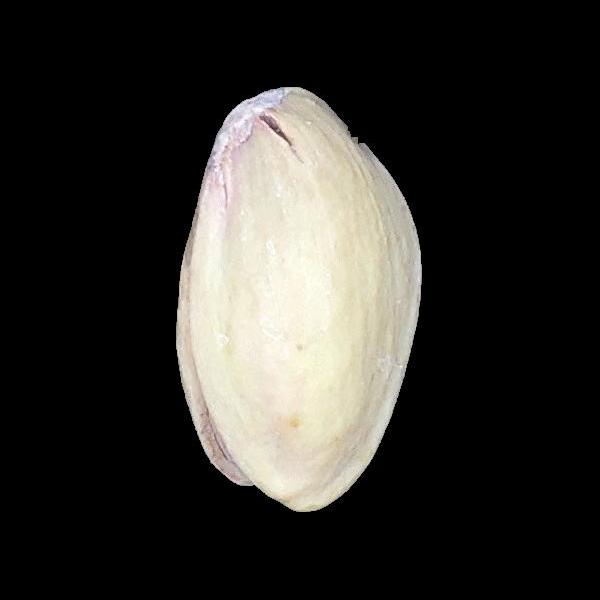

In [19]:
## Random Image from dataset
img = tf.keras.preprocessing.image.load_img(random.choice(total_images))
img

# Data Prep

## Breaking out data into training, validation, and testing sets

Setting the training set to 80% of the data, and the validation and test data to 10% each

In [20]:
train_pct = .8
validation_pct = .1
test_pct = .1
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(train_pct, validation_pct, test_pct))

Copying files: 2148 files [00:00, 6811.29 files/s]


In [21]:
train_path='./output/train/'
val_path='./output/val'
test_path='./output/test'
class_names=os.listdir(train_path)
class_names_val=os.listdir(val_path)
class_names_test=os.listdir(test_path)

In [22]:
train_image1 = glob.glob('./output/train/*/*.jpg')
Total_TrainImages = train_image1
print("Total number of training images: ", len(Total_TrainImages))


test_image1 = glob.glob('./output/test/*/*.jpg')
Total_TestImages = test_image1
print("Total number of test images: ", len(Total_TestImages))



Val_image1 = glob.glob('./output/val/*/*.jpg')

Total_ValImages = Val_image1
print("Total number of val images: ", len(Total_ValImages))

Total number of training images:  1717
Total number of test images:  217
Total number of val images:  214


In [23]:
train_image_names = pd.Series(Total_TrainImages)
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map( lambda img_name: img_name.split("/")[-1])


# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()

,Filename,ClassId
0,siirt 226.jpg,Siirt_Pistachio
1,siirt 475.jpg,Siirt_Pistachio
2,siirt 593.jpg,Siirt_Pistachio
3,siirt 399.jpg,Siirt_Pistachio
4,siirt 614.jpg,Siirt_Pistachio


In [24]:
class_id_distribution_Train = train_df['ClassId'].value_counts()
class_id_distribution_Train.head(10)

Kirmizi_Pistachio    985
Siirt_Pistachio      732
Name: ClassId, dtype: int64

In [25]:
test_image_names = pd.Series(Total_TestImages)
test_df = pd.DataFrame()

# generate Filename field
test_df['Filename'] = test_image_names.map( lambda img_name: img_name.split("/")[-1])


# generate ClassId field
test_df['ClassId'] = test_image_names.map(lambda img_name: img_name.split("/")[-2])

test_df.head()

,Filename,ClassId
0,siirt 25.jpg,Siirt_Pistachio
1,siirt 156.jpg,Siirt_Pistachio
2,siirt 246.jpg,Siirt_Pistachio
3,siirt 249.jpg,Siirt_Pistachio
4,siirt 693.jpg,Siirt_Pistachio


In [26]:
class_id_distribution_test = test_df['ClassId'].value_counts()
class_id_distribution_test.head(10)

Kirmizi_Pistachio    124
Siirt_Pistachio       93
Name: ClassId, dtype: int64

# Exploring the Data

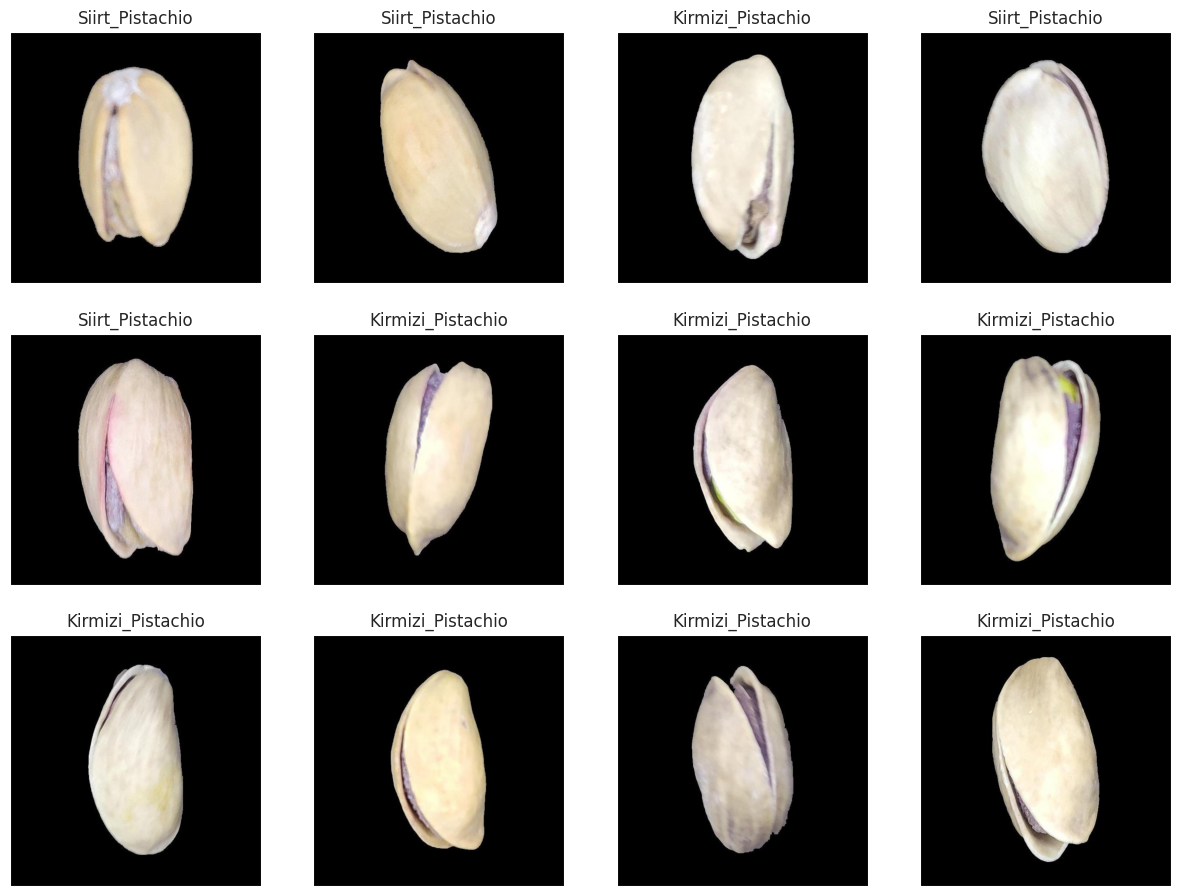

In [27]:
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(train_path,label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])
    plt.yticks([])

In [28]:
## Image Data Generator
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 1717 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


# Training the Model

## Transfer Learning & Fine-Tuning the Model

Since there are several well trained image classification models available, we are going to start with one like EfficientNetB0, and then use Transfer Learning and Fine Tuning to have the model trained for our Pistachio images.

### Load EfficientNetB0 Model

In [33]:
## Download EfficientNetB0 model
model = EfficientNetB0(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

In [34]:
model.trainable = True

In [35]:
## Freezing all but the last 15 layers of the model. This is so we can have the model learn the new image data, but only influence/update the weights
## for the last 15 layers, so that most of the model's weights are left unchanged for now.
for layer in model.layers[:-15]:
    layer.trainable=False

In [36]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

print_layer_trainable()

False:	input_2
False:	rescaling_2
False:	normalization_1
False:	rescaling_3
False:	stem_conv_pad
False:	stem_conv
False:	stem_bn
False:	stem_activation
False:	block1a_dwconv
False:	block1a_bn
False:	block1a_activation
False:	block1a_se_squeeze
False:	block1a_se_reshape
False:	block1a_se_reduce
False:	block1a_se_expand
False:	block1a_se_excite
False:	block1a_project_conv
False:	block1a_project_bn
False:	block2a_expand_conv
False:	block2a_expand_bn
False:	block2a_expand_activation
False:	block2a_dwconv_pad
False:	block2a_dwconv
False:	block2a_bn
False:	block2a_activation
False:	block2a_se_squeeze
False:	block2a_se_reshape
False:	block2a_se_reduce
False:	block2a_se_expand
False:	block2a_se_excite
False:	block2a_project_conv
False:	block2a_project_bn
False:	block2b_expand_conv
False:	block2b_expand_bn
False:	block2b_expand_activation
False:	block2b_dwconv
False:	block2b_bn
False:	block2b_activation
False:	block2b_se_squeeze
False:	block2b_se_reshape
False:	block2b_se_reduce
False:	block2b_

### Add Layers for Transfer Learning

In [37]:
x = Flatten()(model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")

In [38]:
## Updated Model's Structure
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

Output hidden; open in https://colab.research.google.com to view.

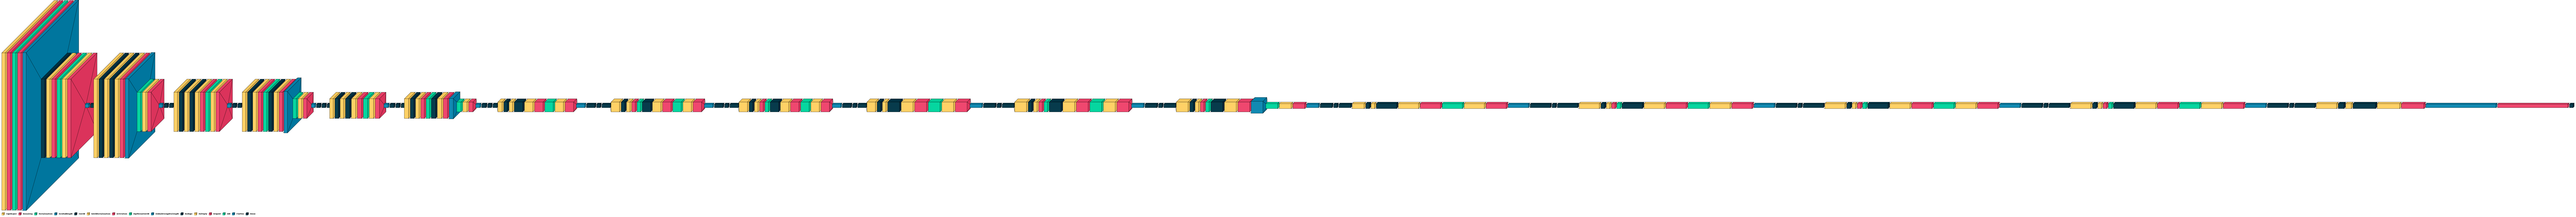

In [39]:
## Visual of the layers for the Pistachio model
visualkeras.layered_view(model, legend=True)

## Training the New Model

In [40]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [41]:
mc = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max',save_best_only=True )

In [ ]:
H = model.fit_generator(train_generator,validation_data=val_generator,epochs=50,verbose=1,callbacks=[mc,es])

Epoch 1/50
54/54 [==============================] - 60s 733ms/step - loss: 0.5658 - accuracy: 0.8556 - val_loss: 1.1162 - val_accuracy: 0.7477
Epoch 2/50
54/54 [==============================] - 31s 584ms/step - loss: 0.1836 - accuracy: 0.9522 - val_loss: 0.4728 - val_accuracy: 0.8925
Epoch 3/50
54/54 [==============================] - 27s 505ms/step - loss: 0.1929 - accuracy: 0.9546 - val_loss: 0.2505 - val_accuracy: 0.9533
Epoch 4/50
54/54 [==============================] - 32s 580ms/step - loss: 0.1774 - accuracy: 0.9586 - val_loss: 0.5332 - val_accuracy: 0.9065
Epoch 5/50
54/54 [==============================] - 26s 489ms/step - loss: 0.1684 - accuracy: 0.9604 - val_loss: 0.4301 - val_accuracy: 0.9346
Epoch 6/50
54/54 [==============================] - 28s 518ms/step - loss: 0.1671 - accuracy: 0.9633 - val_loss: 0.3261 - val_accuracy: 0.9579
Epoch 7/50
54/54 [==============================] - 29s 543ms/step - loss: 0.0949 - accuracy: 0.9761 - val_loss: 0.9310 - val_accuracy: 0.8832

## Best Model

## Other Models Tested

# Measuring Model's Performance & Accuracy

In [ ]:
## Plotting Model's Loss and Accuracy
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']



epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
 print('Loss: %.3f' % (test_loss * 100.0))
 print('Accuracy: %.3f' % (test_acc * 100.0))

Continue from Section [11 Model Evaluation](https://www.kaggle.com/code/abdulbasitniazi/enetb7-explained-98-fine-tuning-eda#11).

# Potential Model Improvements & Future Work

# Appendix

## Additional Models Tested